In [1]:
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.2.1-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
Pandas 2.1.1
Scikit-Learn 1.2.2
GPU is available


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
# IMPORTING STATEMENTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import mutual_information_regression as mri
#import helper_functions_fs as hf

np.random.seed(7)

In [4]:
from sklearn.preprocessing import StandardScaler

# Import the Data & under/over sampling

In [5]:
# training data
data = pd.read_csv('../../0_data/train.csv', index_col=0).reset_index(drop=True)
data.head()

InterestRate  MinorityRatio  CensusTractMedFamIncome  MonthlyIncome  \
0         3.750          5.631                    96500           4693   
1         4.375          5.745                    93258           3194   
2         2.750         21.300                    82260           6344   
3         3.375          4.000                    71172           9776   
4         4.250          8.000                    65755           3800   

   HUDMedIncome   LTV  PaymentCount  Age1  Age2  HousingExpense  ...  \
0         69400  72.0           360    65    61           21.76  ...   
1         94200  79.0           360    34     0           30.74  ...   
2         81700  99.0           360    32    56           27.87  ...   
3         76700  80.0           360    25    25            9.00  ...   
4         73100  80.0           360    30     0           12.00  ...   

   State_31  State_39  State_42  State_48  State_55  State_infrequent_sklearn  \
0       0.0       0.0       0.0       0.0       1.0                       0.0   
1       0.0       0.0       0.0       0.0       1.0                       0.0   
2       0.0       0.0       0.0       0.0       0.0                       0.0   
3       0.0       1.0       0.0       0.0       0.0                       0.0   
4       0.0       1.0       0.0       0.0       0.0                       0.0   

   Minority_Min  Minority_Missing  Minority_White  Borrower2Dummy  
0           0.0               0.0             1.0               1  
1           0.0               0.0             1.0               0  
2           0.0               0.0             1.0               1  
3           0.0               0.0             1.0               1  
4           0.0               0.0             1.0               0  

[5 rows x 74 columns]

In [6]:
# test data
data_test = pd.read_csv('../../0_data/test.csv', index_col=0).reset_index(drop=True)
print(len(data_test))
data_test.head()

47270


InterestRate  MinorityRatio  CensusTractMedFamIncome  MonthlyIncome  \
0         4.000         47.950                    80357          18334   
1         3.250          6.489                   112882          10065   
2         3.475          9.661                   118045          19272   
3         3.125          5.172                   100096           5171   
4         4.750          4.396                    91638          14262   

   HUDMedIncome   LTV  PaymentCount  Age1  Age2  HousingExpense  ...  \
0         95900  80.0           360    39     0           17.07  ...   
1         86200  72.0           360    64    66           20.14  ...   
2         82300  72.0           360    62    62           14.70  ...   
3         89200  80.0           180    43     0           25.31  ...   
4         79600  80.0           360    39    31           12.66  ...   

   State_31  State_39  State_42  State_48  State_55  State_infrequent_sklearn  \
0       0.0       0.0       0.0       1.0       0.0                       0.0   
1       0.0       0.0       0.0       0.0       0.0                       1.0   
2       0.0       0.0       0.0       0.0       1.0                       0.0   
3       0.0       0.0       0.0       0.0       0.0                       0.0   
4       0.0       0.0       0.0       0.0       0.0                       0.0   

   Minority_Min  Minority_Missing  Minority_White  Borrower2Dummy  
0           0.0               0.0             1.0               0  
1           0.0               0.0             1.0               1  
2           0.0               1.0             0.0               1  
3           0.0               0.0             1.0               0  
4           0.0               0.0             1.0               1  

[5 rows x 74 columns]

## UNDER/OVER SAMPLING

We do not consider data points which have missing data regarding the etnicity of the borrower, but only white and minority individuals.

In [7]:
df_minority = data[data['Minority_Min']==1]
df_white = data[data['Minority_White']==1]

print(len(df_minority), len(df_white))

9452 166818


In [8]:
data_test = data_test[data_test['Minority_Missing']!=1]
data_test = data_test.reset_index(drop=True)
print(len(data_test))

44101


We randomly oversample the minority dataset up to 15000 data points, and we will undersample the white dataset to 20000.

In [9]:
from sklearn.utils import resample

In [10]:
df_minority_overs = resample(df_minority, 
                            replace=False,
                            n_samples=5000,   # oversampling
                            random_state=7)

df_white_unders = resample(df_white, 
                            replace=False,
                            n_samples=20000,   # undersampling
                            random_state=7)

In [11]:
df_resampled= pd.concat([df_minority_overs, df_minority, df_white_unders
                        ]).reset_index(drop=True)

In [12]:
# defining response variable and input features
df_resampled.drop(['Minority_Missing', 'Minority_Min'], axis=1, inplace=True)
data_test.drop(['Minority_Missing', 'Minority_Min'], axis=1, inplace=True)

y = df_resampled.pop('InterestRate')
X = df_resampled.copy()

In [13]:
y_test = data_test.pop('InterestRate')
X_test = data_test.copy()

In [14]:
print(len(y_test) , len(X_test))

44101 44101


# Scaling: Standardization
It helps in cases where the features have different units or scales, and you want to ensure that no single feature dominates the learning process.

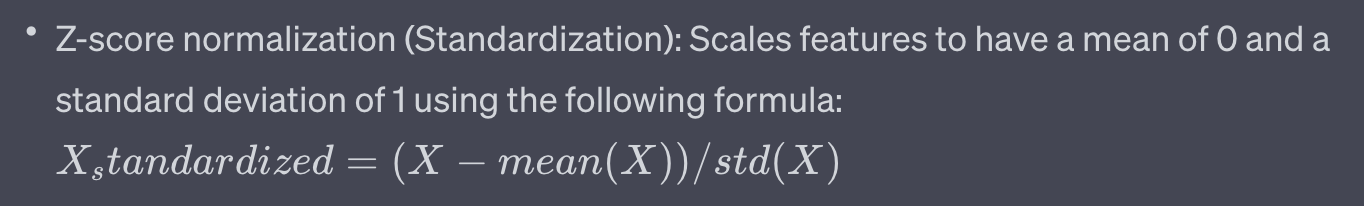


Standardization:
Standardizing the features around the center and 0 with a standard deviation of 1 is important when we compare measurements that have different units. Variables that are measured at different scales do not contribute equally to the analysis and might end up creating a bais.

For example, A variable that ranges between 0 and 1000 will outweigh a variable that ranges between 0 and 1. Using these variables without standardization will give the variable with the larger range weight of 1000 in the analysis. Transforming the data to comparable scales can prevent this problem. Typical data standardization procedures equalize the range and/or data variability.





### ONLY NUMERICAL VARS




In [15]:
numerical = pd.read_csv('../../0_data/numerical.csv', index_col=0)
numerical

0
0              InterestRate
1             MinorityRatio
2   CensusTractMedFamIncome
3             MonthlyIncome
4              HUDMedIncome
5                       LTV
6              PaymentCount
7                      Age1
8                      Age2
9            HousingExpense
10              DebtExpense
11                      PMI
12             CreditScore1
13             CreditScore2
14                 NoteDate
15               NoteAmount

In [16]:
# separate numerical and dummies

X_num = pd.concat([X.pop(col) for col in list(numerical.iloc[1:,0])], axis=1)
X['BorrowerCount'] = X['BorrowerCount']-1

X_test_num = pd.concat([X_test.pop(col) for col in list(numerical.iloc[1:,0])], axis=1)
X_test['BorrowerCount'] = X_test['BorrowerCount']-1

In [17]:
X_num.head()

MinorityRatio  CensusTractMedFamIncome  MonthlyIncome  HUDMedIncome   LTV  \
0         36.561                    84043           5016         83800  95.0   
1          6.997                    69914           4500         84700  80.0   
2         30.684                    49258           7475         65800  95.0   
3          4.495                   121319          30507         83800  72.0   
4         27.780                   106577           7771         94300  72.0   

   PaymentCount  Age1  Age2  HousingExpense  DebtExpense   PMI  CreditScore1  \
0           360    26     0           14.32        22.90  30.0             4   
1           360    39     0           23.12        39.96   0.0             4   
2           360    34    55           19.49        43.61  30.0             2   
3           360    60    53           12.78        17.62   0.0             5   
4           360    36     0           23.91        27.40   0.0             3   

   CreditScore2  NoteDate  NoteAmount  
0             9      2020       79800  
1             9      2021      176000  
2             5      2018      166250  
3             5      2021      506000  
4             9      2019      247400

In [18]:
X.head()

BorrowerCount  FirstTime  SelfEmployed  Bank_Boston  Bank_Chicago  \
0              0          1             0          0.0           1.0   
1              0          0             0          0.0           0.0   
2              1          1             0          0.0           0.0   
3              1          0             0          0.0           1.0   
4              0          1             1          0.0           1.0   

   Bank_Cincinnati  Bank_Dallas  Bank_Des Moines  Bank_Indianapolis  \
0              0.0          0.0              0.0                0.0   
1              0.0          0.0              1.0                0.0   
2              0.0          0.0              0.0                0.0   
3              0.0          0.0              0.0                0.0   
4              0.0          0.0              0.0                0.0   

   Bank_Pittsburgh  ...  State_27  State_29  State_31  State_39  State_42  \
0              0.0  ...       0.0       0.0       0.0       0.0       0.0   
1              0.0  ...       0.0       1.0       0.0       0.0       0.0   
2              0.0  ...       0.0       0.0       0.0       0.0       0.0   
3              0.0  ...       0.0       0.0       0.0       0.0       0.0   
4              0.0  ...       1.0       0.0       0.0       0.0       0.0   

   State_48  State_55  State_infrequent_sklearn  Minority_White  \
0       0.0       1.0                       0.0             0.0   
1       0.0       0.0                       0.0             0.0   
2       0.0       0.0                       1.0             0.0   
3       0.0       1.0                       0.0             0.0   
4       0.0       0.0                       0.0             0.0   

   Borrower2Dummy  
0               0  
1               0  
2               1  
3               1  
4               0  

[5 rows x 56 columns]

In [19]:
print(len(y_test) , len(X_test))

44101 44101


In [20]:
# scale numerical vars 
ss = StandardScaler()
X_train_num = ss.fit_transform(X_num)
X_test_num = ss.transform(X_test_num)
X_num = pd.DataFrame(X_train_num, columns=list(numerical.iloc[1:,0]))
X_test_num = pd.DataFrame(X_test_num, columns=list(numerical.iloc[1:,0]))
X_num.describe()

MinorityRatio  CensusTractMedFamIncome  MonthlyIncome  HUDMedIncome  \
count   3.445200e+04             3.445200e+04   3.445200e+04  3.445200e+04   
mean    7.589682e-17             1.600433e-16   1.499375e-16 -1.303445e-16   
std     1.000015e+00             1.000015e+00   1.000015e+00  1.000015e+00   
min    -1.101336e+00            -2.777314e+00  -1.543407e+00 -2.792502e+00   
25%    -7.831669e-01            -6.949555e-01  -7.064585e-01 -6.940839e-01   
50%    -3.832157e-01            -1.988504e-01  -2.257226e-01 -8.416305e-02   
75%     5.168806e-01             5.326246e-01   4.022542e-01  4.313653e-01   
max     2.218873e+00             3.690325e+00   3.721661e+00  3.451926e+00   

                LTV  PaymentCount          Age1          Age2  HousingExpense  \
count  3.445200e+04  3.445200e+04  3.445200e+04  3.445200e+04    3.445200e+04   
mean  -1.102154e-15 -1.608683e-16 -1.843798e-16 -5.032289e-17   -5.114786e-17   
std    1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00    1.000015e+00   
min   -8.920699e-01 -3.797081e+00 -2.056757e+00 -9.827591e-01   -2.406709e+00   
25%   -8.920699e-01  5.431438e-01 -7.453544e-01 -9.827591e-01   -7.377402e-01   
50%   -4.470045e-02  5.431438e-01 -1.282240e-01  1.417488e-01   -1.496608e-01   
75%    7.635232e-02  5.431438e-01  6.431890e-01  8.081239e-01    5.877907e-01   
max    4.797410e+00  5.431438e-01  3.883124e+00  2.848897e+00    3.979833e+00   

        DebtExpense           PMI  CreditScore1  CreditScore2      NoteDate  \
count  3.445200e+04  3.445200e+04  3.445200e+04  3.445200e+04  3.445200e+04   
mean   7.721677e-16  1.649931e-18  1.361193e-16 -1.006458e-16 -6.847832e-14   
std    1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00   
min   -3.210590e+00 -4.406672e-01 -3.916743e+00 -2.361588e+00 -6.827623e+00   
25%   -7.535352e-01 -4.406672e-01 -3.841378e-01 -6.650030e-01 -9.388354e-01   
50%    3.374604e-02 -4.406672e-01  7.933972e-01 -6.650030e-01  2.389222e-01   
75%    7.872428e-01 -4.406672e-01  7.933972e-01  1.031582e+00  1.416680e+00   
max    4.778933e+00  4.889271e+00  7.933972e-01  1.031582e+00  1.416680e+00   

         NoteAmount  
count  3.445200e+04  
mean  -7.919668e-17  
std    1.000015e+00  
min   -1.711096e+00  
25%   -7.543072e-01  
50%   -2.095826e-01  
75%    5.520129e-01  
max    3.970345e+00

In [21]:
## merge back together numerical and dummies
X = pd.concat([X, X_num], axis=1, ignore_index=False)
X_test = pd.concat([X_test, X_test_num], axis=1,ignore_index=False)

In [22]:
X_test

BorrowerCount  FirstTime  SelfEmployed  Bank_Boston  Bank_Chicago  \
0                  0          0             0          0.0           0.0   
1                  1          0             0          0.0           0.0   
2                  0          0             0          0.0           0.0   
3                  1          1             1          0.0           1.0   
4                  1          0             0          0.0           0.0   
...              ...        ...           ...          ...           ...   
44096              1          0             0          0.0           0.0   
44097              1          0             0          0.0           0.0   
44098              1          1             1          0.0           0.0   
44099              1          0             0          0.0           0.0   
44100              0          0             0          0.0           0.0   

       Bank_Cincinnati  Bank_Dallas  Bank_Des Moines  Bank_Indianapolis  \
0                  0.0          1.0              0.0                0.0   
1                  0.0          0.0              1.0                0.0   
2                  0.0          0.0              1.0                0.0   
3                  0.0          0.0              0.0                0.0   
4                  0.0          1.0              0.0                0.0   
...                ...          ...              ...                ...   
44096              1.0          0.0              0.0                0.0   
44097              0.0          0.0              1.0                0.0   
44098              0.0          0.0              0.0                1.0   
44099              0.0          0.0              0.0                0.0   
44100              0.0          0.0              0.0                0.0   

       Bank_Pittsburgh  ...  PaymentCount      Age1      Age2  HousingExpense  \
0                  0.0  ...      0.543144 -0.436789 -0.982759       -0.399006   
1                  0.0  ...      0.543144  1.491743  1.766038       -0.037926   
2                  0.0  ...     -2.060991 -0.128224 -0.982759        0.570148   
3                  0.0  ...      0.543144 -0.436789  0.308343       -0.917692   
4                  0.0  ...      0.543144 -0.513931  0.724827       -0.855356   
...                ...  ...           ...       ...       ...             ...   
44096              0.0  ...      0.543144  0.643189  1.141311        0.063224   
44097              0.0  ...      0.543144 -1.053920  0.308343       -1.065888   
44098              0.0  ...     -2.929036  0.103200  1.099663        0.038525   
44099              0.0  ...      0.543144 -0.128224  0.599882       -0.690694   
44100              1.0  ...      0.543144 -0.976778 -0.982759        1.033555   

       DebtExpense       PMI  CreditScore1  CreditScore2  NoteDate  NoteAmount  
0         0.134076 -0.440667     -0.384138      1.031582 -0.938835    0.827988  
1        -1.041215 -0.440667      0.793397     -0.665003  0.238922   -0.053947  
2         0.837408 -0.440667     -1.561673      1.031582  0.238922   -0.766906  
3         0.157623 -0.440667      0.793397     -0.665003 -0.938835   -0.091596  
4         0.709436  2.634297      0.793397     -1.513296  0.238922   -0.790215  
...            ...       ...           ...           ...       ...         ...  
44096    -0.753535 -0.440667      0.793397     -0.665003 -0.938835    0.776110  
44097    -1.562316 -0.440667      0.793397     -0.665003 -0.938835   -0.833311  
44098     0.411518 -0.440667      0.793397     -0.665003 -0.938835   -0.031713  
44099     1.126112 -0.440667      0.793397     -1.937442 -0.938835   -0.676489  
44100     1.302200  2.121803      0.793397      1.031582  1.416680   -0.209583  

[44101 rows x 71 columns]

In [23]:
print(len(y) , len(X),  len(X_num))

34452 34452 34452


In [24]:
print(len(y_test) , len(X_test),  len(X_test_num))

44101 44101 44101


In [25]:
X.describe()

BorrowerCount     FirstTime  SelfEmployed   Bank_Boston  Bank_Chicago  \
count   34452.000000  34452.000000  34452.000000  34452.000000  34452.000000   
mean        0.533467      0.230001      0.224196      0.030245      0.266109   
std         0.498886      0.420839      0.417058      0.171263      0.441929   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         0.000000      0.000000      0.000000      0.000000      0.000000   
50%         1.000000      0.000000      0.000000      0.000000      0.000000   
75%         1.000000      0.000000      0.000000      0.000000      1.000000   
max         1.000000      1.000000      1.000000      1.000000      1.000000   

       Bank_Cincinnati   Bank_Dallas  Bank_Des Moines  Bank_Indianapolis  \
count     34452.000000  34452.000000     34452.000000       34452.000000   
mean          0.119354      0.092883         0.123883           0.086962   
std           0.324210      0.290272         0.329452           0.281783   
min           0.000000      0.000000         0.000000           0.000000   
25%           0.000000      0.000000         0.000000           0.000000   
50%           0.000000      0.000000         0.000000           0.000000   
75%           0.000000      0.000000         0.000000           0.000000   
max           1.000000      1.000000         1.000000           1.000000   

       Bank_Pittsburgh  ...  PaymentCount          Age1          Age2  \
count     34452.000000  ...  3.445200e+04  3.445200e+04  3.445200e+04   
mean          0.064089  ... -1.608683e-16 -1.843798e-16 -5.032289e-17   
std           0.244915  ...  1.000015e+00  1.000015e+00  1.000015e+00   
min           0.000000  ... -3.797081e+00 -2.056757e+00 -9.827591e-01   
25%           0.000000  ...  5.431438e-01 -7.453544e-01 -9.827591e-01   
50%           0.000000  ...  5.431438e-01 -1.282240e-01  1.417488e-01   
75%           0.000000  ...  5.431438e-01  6.431890e-01  8.081239e-01   
max           1.000000  ...  5.431438e-01  3.883124e+00  2.848897e+00   

       HousingExpense   DebtExpense           PMI  CreditScore1  CreditScore2  \
count    3.445200e+04  3.445200e+04  3.445200e+04  3.445200e+04  3.445200e+04   
mean    -5.114786e-17  7.721677e-16  1.649931e-18  1.361193e-16 -1.006458e-16   
std      1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00   
min     -2.406709e+00 -3.210590e+00 -4.406672e-01 -3.916743e+00 -2.361588e+00   
25%     -7.377402e-01 -7.535352e-01 -4.406672e-01 -3.841378e-01 -6.650030e-01   
50%     -1.496608e-01  3.374604e-02 -4.406672e-01  7.933972e-01 -6.650030e-01   
75%      5.877907e-01  7.872428e-01 -4.406672e-01  7.933972e-01  1.031582e+00   
max      3.979833e+00  4.778933e+00  4.889271e+00  7.933972e-01  1.031582e+00   

           NoteDate    NoteAmount  
count  3.445200e+04  3.445200e+04  
mean  -6.847832e-14 -7.919668e-17  
std    1.000015e+00  1.000015e+00  
min   -6.827623e+00 -1.711096e+00  
25%   -9.388354e-01 -7.543072e-01  
50%    2.389222e-01 -2.095826e-01  
75%    1.416680e+00  5.520129e-01  
max    1.416680e+00  3.970345e+00  

[8 rows x 71 columns]

In [26]:
X_test.describe()

BorrowerCount     FirstTime  SelfEmployed   Bank_Boston  Bank_Chicago  \
count   44101.000000  44101.000000  44101.000000  44101.000000   44101.00000   
mean        0.601188      0.197479      0.215279      0.028276       0.26013   
std         0.489659      0.398101      0.411020      0.165762       0.43871   
min         0.000000      0.000000      0.000000      0.000000       0.00000   
25%         0.000000      0.000000      0.000000      0.000000       0.00000   
50%         1.000000      0.000000      0.000000      0.000000       0.00000   
75%         1.000000      0.000000      0.000000      0.000000       1.00000   
max         1.000000      1.000000      1.000000      1.000000       1.00000   

       Bank_Cincinnati   Bank_Dallas  Bank_Des Moines  Bank_Indianapolis  \
count     44101.000000  44101.000000     44101.000000       44101.000000   
mean          0.126392      0.063604         0.151289           0.106959   
std           0.332294      0.244049         0.358334           0.309065   
min           0.000000      0.000000         0.000000           0.000000   
25%           0.000000      0.000000         0.000000           0.000000   
50%           0.000000      0.000000         0.000000           0.000000   
75%           0.000000      0.000000         0.000000           0.000000   
max           1.000000      1.000000         1.000000           1.000000   

       Bank_Pittsburgh  ...  PaymentCount          Age1          Age2  \
count     44101.000000  ...  44101.000000  44101.000000  44101.000000   
mean          0.062062  ...     -0.059246      0.006583      0.121445   
std           0.241271  ...      1.033488      1.031903      0.993441   
min           0.000000  ...     -3.551135     -2.056757     -0.982759   
25%           0.000000  ...     -1.192946     -0.822496     -0.982759   
50%           0.000000  ...      0.543144     -0.128224      0.308343   
75%           0.000000  ...      0.543144      0.720330      0.891421   
max           1.000000  ...      0.543144      3.805982      2.932194   

       HousingExpense   DebtExpense           PMI  CreditScore1  CreditScore2  \
count    44101.000000  44101.000000  44101.000000  44101.000000  44101.000000   
mean        -0.148608     -0.124716     -0.046023      0.098507     -0.116232   
std          0.934626      0.979155      0.955350      0.944312      0.971328   
min         -2.406709     -3.108212     -0.440667     -3.916743     -2.361588   
25%         -0.815367     -0.855912     -0.440667     -0.384138     -0.665003   
50%         -0.289624     -0.124939     -0.440667      0.793397     -0.665003   
75%          0.392548      0.638796     -0.440667      0.793397      1.031582   
max          3.979833      5.163871      7.554241      0.793397      1.031582   

           NoteDate    NoteAmount  
count  44101.000000  44101.000000  
mean       0.050565     -0.134873  
std        0.975486      0.903300  
min       -6.827623     -1.673795  
25%       -0.938835     -0.809891  
50%        0.238922     -0.328162  
75%        1.416680      0.353670  
max        1.416680      3.970345  

[8 rows x 71 columns]

In [27]:
# dependent variables
ss_y = StandardScaler()
y = ss_y.fit_transform(np.array(y).reshape(-1, 1))
y_test = ss_y.transform(np.array(y_test).reshape(-1, 1))
pd.Series(y.flatten()).describe()

count    3.445200e+04
mean    -6.187241e-16
std      1.000015e+00
min     -2.497910e+00
25%     -8.125658e-01
50%     -6.352377e-02
75%      6.855183e-01
max      3.868947e+00
dtype: float64

# TODO: Scoring Methods

We define a helper function to save the scores for each model and make a final comparison.

The metrics we will analyse are: 
- MSE: Mean Squared Error
- MAE: Mean Absolute Error
- MR: Mean Residual
- **R2 ???????**
- **FAIRNESS QUALCOSA!!! TODO!!**

# PRENDERE DA ONE NOTE !!!!

In [28]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


def mean_residual(y_true, prediction):
    '''Compute the mean residual metric'''
    residuals = (y_true - prediction)
    MR = residuals.mean()
    return MR


def compute_scores(x, y_true, y_pred):
    '''Compute the following metrics for the given model: MSE, MAE, MR, r2'''
    #y_true = y_true.reshape(y_pred.shape)

    MSE = mean_squared_error(y_true, y_pred)
    print(f"MSE: {MSE:.4f}")
    MAE = mean_absolute_error(y_true, y_pred)
    print(f"MAE: {MAE:.4f}")
    MR = mean_residual(y_true, y_pred)
    print(f"MR: {MR:.4f}")
    R2 = r2_score(y_true, y_pred)
    adj_R2 = 1- ((1-R2) * (x.shape[0]-1)/(x.shape[0]-x.shape[1]-1))
    print(f"adj-R2: {adj_R2:.4f}")
    return [MSE, MAE, MR, adj_R2]


def save_scores(model, scores):
    '''Store scores for the given model into a dedicated dataframe for a final comparison across models'''
    MSE, MAE, MR, r2 = scores
    pd.Series(scores).to_csv('scores/'+model)
    model_names.append(model)
    MSEs.append(MSE)
    MAEs.append(MAE)
    MRs.append(MR)
    r2s.append(r2)
    

def display_scores():
    scores_df = pd.DataFrame([model_names, MSEs, MAEs, MRs, r2s], 
                 index=['method', 'MSE', 'MAE', 'MR', 'adj R-squared']).T
    return scores_df

In [29]:
model_names, MSEs, MAEs, MRs, r2s = [],[],[],[],[]

In [30]:
def export_pred(y_pred_std, model, scaler=ss_y):
    '''Reverts model predictions to the original scale of the input data and then saves it to a csv file'''

    y_pred = scaler.inverse_transform(np.array(y_pred_std, ndmin=2)).flatten()
    np.savetxt('predictions/'+str(model)+'_pred.csv', y_pred, delimiter=",")

# MODELS

# 1. Linear Regression

In [31]:
import statsmodels.api as sm

In [32]:
#add constant to predictor variables
x = sm.add_constant(X)
#fit linear regression model
lr = sm.OLS(y, x).fit()

#view model summary
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     1381.
Date:                Wed, 04 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:33:19   Log-Likelihood:                -27964.
No. Observations:               34452   AIC:                         5.605e+04
Df Residuals:                   34392   BIC:                         5.656e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [33]:
X_TEST = sm.add_constant(X_test)
lr_pred = lr.predict(X_TEST)
len(lr_pred)

44101

In [34]:
len(X_test)

44101

In [35]:
len(y_test)

44101

In [36]:

scores = compute_scores(X_TEST, y_test.flatten(), list(lr_pred))
save_scores('LinearRegression', scores)

MSE: 0.2842
MAE: 0.4170
MR: -0.0113
adj-R2: 0.7013


In [37]:
pd.DataFrame(X_test.iloc[14,:]).to_csv('errore.csv')

In [38]:
list(lr_pred)[14]

-0.8810282612716834

In [39]:
export_pred(lr_pred, 'LinearRegression')

# 2. RANSAC

https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py

In [40]:
from sklearn import linear_model

In [41]:
# Robustly fit linear model with RANSAC algorithm to avoid outlier interference
ransac = linear_model.RANSACRegressor().fit(X, y)

In [42]:
ransac_pred = ransac.predict(X_test)
scores = compute_scores(X_test, y_test, ransac_pred)
save_scores('RANSAC', scores)

MSE: 0.3512
MAE: 0.4640
MR: -0.0272
adj-R2: 0.6310


In [43]:
export_pred(ransac_pred, 'RANSAC')

# 3. DNN

*Wang 2022:*

- three hidden layers are used with 10 nodes in the first hidden layer, 8 nodes in the second hidden layer, and 6 nodes in the third hidden layer. 
- All layers use tanh activation function. 
- Mean square error is used as the cost function. 
- Stochastic gradient descent algorithm with a batch size of 64 and epoch of 100 is used to train the weights. 

## Neural Networks


For neural networks, we experiment with different network configurations and pick the best in terms of 
# #TODO: scegliere metriche

on the validation set. 


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

In [45]:
from sklearn.model_selection import train_test_split
# Splitting data with a 15/85% val train split
X_tr, X_val, y_tr, y_val = train_test_split(X, y, random_state=7, test_size=0.15)

In [46]:
# Custom function to create the model based on the arguments passed
def create_model(layers,  activation='tanh',  X_train=X_tr): #dropout_rate,
    model = None
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes, input_dim = X_train.shape[1]))
            model.add(Activation(activation))
        else:
#            model.add(Dropout(dropout_rate[i-1], seed=0))   # worse performance with dropout
            model.add(Dense(nodes))
            model.add(Activation(activation))
#            model.add(Dropout(dropout_rate, seed=0))

    # final prediction
    model.add(Dense(1)) 
    
    # compile model
    model.compile(optimizer='sgd', # stochastic gradient descent
                  loss='mean_squared_error', # loss function chosen
                  metrics=None) # TODO !
    return model


# Custom callback to calculate R2 score
class R2ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(R2ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.last_r2_score = None  # Store the last R2 score here

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val)
        r2 = self.calculate_r2(y_val, y_pred)
        self.last_r2_score = r2  # Store the R2 score
        print(f'Validation R2 Score: {r2:.4f}')

    @staticmethod
    def calculate_r2(y_true, y_pred):
        mean_y_true = np.mean(y_true)
        ss_total = np.sum((y_true - mean_y_true) ** 2)
        ss_residual = np.sum((y_true - y_pred) ** 2)
        r2 = 1 - (ss_residual / ss_total)
        return r2

We try out different configurations for the architechture of the neural network to find the most fitting one. 

(source: https://www.kdnuggets.com/2019/11/designing-neural-networks.html)

In [47]:
layers = [[10,8,6], [44, 24, 10], [16, 10, 8, 6], [54, 36, 24, 10]]   
act = 'tanh'
#dropouts = [[0, 0],[0.2, 0.1], [0.2, 0.1], [0.2,0.1,0.05], [0.2,0.1,0.05,0]]

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
scores2 = pd.DataFrame(columns=['layers','activation','val_mean_squared_error', 'val_R2'], index=np.arange(len(layers)))
histories=[]

for i, lay in enumerate(layers):
    print(f"Layer configuration number {i}: {lay}")
#    for j, act in enumerate(activations):
    print(f"activation: {act} \n")
    model = create_model(lay, activation=act) #dropouts[i],

    # Create callbacks instances
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001,patience=10,
                                verbose=1,mode='auto')
    r2_callback = R2ScoreCallback(validation_data=(X_val, y_val))

    history = model.fit(X_tr, y_tr, validation_data=(X_val,y_val), 
                        epochs=100, batch_size=254, verbose=1, callbacks=[earlystop, r2_callback]
                       )  
    # save scores and model
    last_r2_score = r2_callback.last_r2_score # Access the last R2 score
    scores2.iloc[i,:] = [lay, act,  history.history['val_loss'][-1], last_r2_score]
    histories.append(history.history)
    path = 'saved_nn/model' + str(i) #+'.'+str(j)
    model.save(path)
    print('\n\n')

Layer configuration number 0: [10, 8, 6]
activation: tanh 

Metal device set to: Apple M2
Epoch 1/100


2023-10-04 16:33:25.831697: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.5848
116/116 [==============================] - 1s 8ms/step - loss: 0.5960 - val_loss: 0.3981
Epoch 2/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.6347
116/116 [==============================] - 1s 6ms/step - loss: 0.3906 - val_loss: 0.3503
Epoch 3/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.6560
116/116 [==============================] - 1s 7ms/step - loss: 0.3570 - val_loss: 0.3299
Epoch 4/100
162/162 [==============================] - 0s 1ms/steposs
Validation R2 Score: 0.6678
116/116 [==============================] - 1s 6ms/step - loss: 0.3386 - val_loss: 0.3186
Epoch 5/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.6756
116/116 [==============================] - 1s 7ms/step - loss: 0.3265 - val_loss: 0.3111
Epoch 6/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Sco

Epoch 45/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7295
116/116 [==============================] - 1s 6ms/step - loss: 0.2598 - val_loss: 0.2594
Epoch 46/100
162/162 [==============================] - 0s 1ms/steposs
Validation R2 Score: 0.7291
116/116 [==============================] - 1s 6ms/step - loss: 0.2594 - val_loss: 0.2598
Epoch 47/100
162/162 [==============================] - 0s 1ms/steposs
Validation R2 Score: 0.7298
116/116 [==============================] - 1s 6ms/step - loss: 0.2591 - val_loss: 0.2591
Epoch 48/100
162/162 [==============================] - 0s 1ms/steposs
Validation R2 Score: 0.7291
116/116 [==============================] - 1s 6ms/step - loss: 0.2587 - val_loss: 0.2598
Epoch 49/100
162/162 [==============================] - 0s 1ms/steposs
Validation R2 Score: 0.7304
116/116 [==============================] - 1s 6ms/step - loss: 0.2583 - val_loss: 0.2586
Epoch 50/100
162/162 [==============================] - 0s 1ms

Epoch 89/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7396
116/116 [==============================] - 1s 6ms/step - loss: 0.2461 - val_loss: 0.2498
Epoch 90/100
162/162 [==============================] - 0s 1ms/steposs
Validation R2 Score: 0.7399
116/116 [==============================] - 1s 6ms/step - loss: 0.2459 - val_loss: 0.2494
Epoch 91/100
162/162 [==============================] - 0s 1ms/steposs
Validation R2 Score: 0.7404
116/116 [==============================] - 1s 6ms/step - loss: 0.2456 - val_loss: 0.2490
Epoch 92/100
162/162 [==============================] - 0s 1ms/steposs
Validation R2 Score: 0.7408
116/116 [==============================] - 1s 6ms/step - loss: 0.2453 - val_loss: 0.2485
Epoch 93/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7413
116/116 [==============================] - 1s 6ms/step - loss: 0.2451 - val_loss: 0.2481
Epoch 94/100
162/162 [==============================] - 0s 1ms/s

162/162 [==============================] - 0s 1ms/steposs
Validation R2 Score: 0.7388
116/116 [==============================] - 1s 6ms/step - loss: 0.2482 - val_loss: 0.2505
Epoch 33/100
162/162 [==============================] - 0s 1ms/steposs
Validation R2 Score: 0.7399
116/116 [==============================] - 1s 6ms/step - loss: 0.2475 - val_loss: 0.2494
Epoch 34/100
162/162 [==============================] - 0s 1ms/steposs
Validation R2 Score: 0.7400
116/116 [==============================] - 1s 6ms/step - loss: 0.2469 - val_loss: 0.2494
Epoch 35/100
162/162 [==============================] - 0s 1ms/steposs
Validation R2 Score: 0.7410
116/116 [==============================] - 1s 6ms/step - loss: 0.2461 - val_loss: 0.2484
Epoch 36/100
162/162 [==============================] - 0s 1ms/steposs
Validation R2 Score: 0.7409
116/116 [==============================] - 1s 6ms/step - loss: 0.2456 - val_loss: 0.2484
Epoch 37/100
162/162 [==============================] - 0s 1ms/steposs
Va

Epoch 76/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7557
116/116 [==============================] - 1s 6ms/step - loss: 0.2278 - val_loss: 0.2343
Epoch 77/100
162/162 [==============================] - 0s 1ms/steposs
Validation R2 Score: 0.7563
116/116 [==============================] - 1s 6ms/step - loss: 0.2275 - val_loss: 0.2337
Epoch 78/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7566
116/116 [==============================] - 1s 6ms/step - loss: 0.2271 - val_loss: 0.2334
Epoch 79/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7577
116/116 [==============================] - 1s 6ms/step - loss: 0.2268 - val_loss: 0.2324
Epoch 80/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7576
116/116 [==============================] - 1s 7ms/step - loss: 0.2265 - val_loss: 0.2325
Epoch 81/100
162/162 [==============================] - 0s 2ms/stepo

Epoch 20/100
162/162 [==============================] - 0s 2ms/step
Validation R2 Score: 0.7192
116/116 [==============================] - 1s 9ms/step - loss: 0.2722 - val_loss: 0.2693
Epoch 21/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7201
116/116 [==============================] - 1s 7ms/step - loss: 0.2711 - val_loss: 0.2685
Epoch 22/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7202
116/116 [==============================] - 1s 6ms/step - loss: 0.2700 - val_loss: 0.2684
Epoch 23/100
162/162 [==============================] - 0s 2ms/stepo
Validation R2 Score: 0.7216
116/116 [==============================] - 1s 7ms/step - loss: 0.2690 - val_loss: 0.2669
Epoch 24/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7232
116/116 [==============================] - 1s 7ms/step - loss: 0.2681 - val_loss: 0.2654
Epoch 25/100
162/162 [==============================] - 0s 1ms/stepo
Va

162/162 [==============================] - 0s 2ms/step
Validation R2 Score: 0.7424
116/116 [==============================] - 1s 7ms/step - loss: 0.2451 - val_loss: 0.2471
Epoch 65/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7423
116/116 [==============================] - 1s 7ms/step - loss: 0.2447 - val_loss: 0.2471
Epoch 66/100
162/162 [==============================] - 0s 2ms/stepo
Validation R2 Score: 0.7432
116/116 [==============================] - 1s 7ms/step - loss: 0.2443 - val_loss: 0.2463
Epoch 67/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7425
116/116 [==============================] - 1s 7ms/step - loss: 0.2439 - val_loss: 0.2469
Epoch 68/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7435
116/116 [==============================] - 1s 7ms/step - loss: 0.2435 - val_loss: 0.2460
Epoch 69/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 S

Epoch 8/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7143
116/116 [==============================] - 1s 7ms/step - loss: 0.2796 - val_loss: 0.2740
Epoch 9/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7180
116/116 [==============================] - 1s 7ms/step - loss: 0.2753 - val_loss: 0.2705
Epoch 10/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7209
116/116 [==============================] - 1s 6ms/step - loss: 0.2717 - val_loss: 0.2677
Epoch 11/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7243
116/116 [==============================] - 1s 6ms/step - loss: 0.2687 - val_loss: 0.2644
Epoch 12/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7264
116/116 [==============================] - 1s 6ms/step - loss: 0.2663 - val_loss: 0.2624
Epoch 13/100
162/162 [==============================] - 0s 1ms/stepo
Val

162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7520
116/116 [==============================] - 1s 6ms/step - loss: 0.2320 - val_loss: 0.2378
Epoch 53/100
162/162 [==============================] - 0s 2ms/stepo
Validation R2 Score: 0.7538
116/116 [==============================] - 1s 7ms/step - loss: 0.2316 - val_loss: 0.2361
Epoch 54/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7541
116/116 [==============================] - 1s 7ms/step - loss: 0.2312 - val_loss: 0.2358
Epoch 55/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7541
116/116 [==============================] - 1s 7ms/step - loss: 0.2305 - val_loss: 0.2358
Epoch 56/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7539
116/116 [==============================] - 1s 7ms/step - loss: 0.2302 - val_loss: 0.2360
Epoch 57/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 

162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7655
116/116 [==============================] - 1s 6ms/step - loss: 0.2168 - val_loss: 0.2249
Epoch 97/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7655
116/116 [==============================] - 1s 6ms/step - loss: 0.2167 - val_loss: 0.2249
Epoch 98/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7647
116/116 [==============================] - 1s 6ms/step - loss: 0.2164 - val_loss: 0.2256
Epoch 99/100
162/162 [==============================] - 0s 2ms/stepo
Validation R2 Score: 0.7655
116/116 [==============================] - 1s 6ms/step - loss: 0.2162 - val_loss: 0.2248
Epoch 100/100
162/162 [==============================] - 0s 1ms/stepo
Validation R2 Score: 0.7646
116/116 [==============================] - 1s 7ms/step - loss: 0.2159 - val_loss: 0.2257
INFO:tensorflow:Assets written to: saved_nn/model3/assets





In [50]:
scores2 # first layer config is from Wang 2022

layers activation val_mean_squared_error    val_R2
0        [10, 8, 6]       tanh               0.247934  0.741468
1      [44, 24, 10]       tanh               0.228954  0.761258
2    [16, 10, 8, 6]       tanh               0.239925  0.749819
3  [54, 36, 24, 10]       tanh               0.225735  0.764615

# TODO: reimport the chosen model and predict


In [62]:
from tensorflow.keras import models

# TODO:
best_nn = models.load_model('saved_nn/model' + '1')

In [63]:
nn_pred = best_nn.predict(X_test)
scores = compute_scores(X_test, y_test, nn_pred)
save_scores('NeuralNetwork', scores)

1379/1379 [==============================] - 2s 1ms/step
MSE: 0.2200
MAE: 0.3639
MR: 0.0151
adj-R2: 0.7689


In [64]:
export_pred(nn_pred, 'NeuralNetwork')

In [65]:
display_scores()

method       MSE       MAE        MR adj R-squared
0  LinearRegression  0.284242  0.417012 -0.011339      0.701304
1            RANSAC  0.351169  0.464005 -0.027247      0.630982
2     NeuralNetwork  0.219969  0.363906  0.015084       0.76885
3     NeuralNetwork  0.218082  0.361823  0.034362      0.770834
4     NeuralNetwork  0.219969  0.363906  0.015084       0.76885

done twice, picked model config n 1, less complex and same results as last one 

# 4. Regression Tree

In [66]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [67]:
tree = GridSearchCV(
    DecisionTreeRegressor(max_depth=2),
    param_grid={"max_depth": range(3,22,3)}, 
    scoring= 'neg_mean_squared_error', 
    verbose=3)

In [68]:
tree.fit(X, y)
print(f"\nBest Tree with params: {tree.best_params_} and MSE: {tree.best_score_:.3f}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ......................max_depth=3;, score=-0.365 total time=   0.1s
[CV 2/5] END ......................max_depth=3;, score=-0.370 total time=   0.1s
[CV 3/5] END ......................max_depth=3;, score=-0.299 total time=   0.1s
[CV 4/5] END ......................max_depth=3;, score=-0.290 total time=   0.1s
[CV 5/5] END ......................max_depth=3;, score=-0.287 total time=   0.1s
[CV 1/5] END ......................max_depth=6;, score=-0.292 total time=   0.1s
[CV 2/5] END ......................max_depth=6;, score=-0.293 total time=   0.1s
[CV 3/5] END ......................max_depth=6;, score=-0.248 total time=   0.1s
[CV 4/5] END ......................max_depth=6;, score=-0.242 total time=   0.1s
[CV 5/5] END ......................max_depth=6;, score=-0.243 total time=   0.1s
[CV 1/5] END ......................max_depth=9;, score=-0.254 total time=   0.2s
[CV 2/5] END ......................max_depth=9;, 

The optimal tree must have a depth around **9**. Therefore, we perform a second cross validation around this number.

In [69]:
tree = GridSearchCV(
    DecisionTreeRegressor(max_depth=2),
    param_grid={"max_depth": range(6,12,1)},
    scoring= 'neg_mean_squared_error', 
    verbose=3)

tree.fit(X, y)
print(f"\nBest Tree with params: {tree.best_params_} and MSE: {tree.best_score_:.3f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ......................max_depth=6;, score=-0.292 total time=   0.1s
[CV 2/5] END ......................max_depth=6;, score=-0.293 total time=   0.1s
[CV 3/5] END ......................max_depth=6;, score=-0.248 total time=   0.1s
[CV 4/5] END ......................max_depth=6;, score=-0.242 total time=   0.1s
[CV 5/5] END ......................max_depth=6;, score=-0.243 total time=   0.1s
[CV 1/5] END ......................max_depth=7;, score=-0.277 total time=   0.1s
[CV 2/5] END ......................max_depth=7;, score=-0.280 total time=   0.1s
[CV 3/5] END ......................max_depth=7;, score=-0.246 total time=   0.1s
[CV 4/5] END ......................max_depth=7;, score=-0.239 total time=   0.1s
[CV 5/5] END ......................max_depth=7;, score=-0.241 total time=   0.1s
[CV 1/5] END ......................max_depth=8;, score=-0.267 total time=   0.2s
[CV 2/5] END ......................max_depth=8;, 

In [72]:
# Creating regression model with selected number of splits
best_tree = DecisionTreeRegressor(max_depth=tree.best_params_['max_depth'])
best_tree.fit(X, y)

DecisionTreeRegressor(max_depth=10)

In [73]:
tree_pred = best_tree.predict(X_test)
scores = compute_scores(X_test, y_test, tree_pred)
save_scores('RegressionTree', scores)

MSE: 0.2404
MAE: 0.3730
MR: -0.0014
adj-R2: 0.7474


In [74]:
export_pred(tree_pred, 'RegressionTree')

# 5. Random Forest

In [75]:
from sklearn.ensemble import RandomForestRegressor

## GRIDSEARCH CV

https://www.researchgate.net/publication/230766603_How_Many_Trees_in_a_Random_Forest citare !! per numero di trees:

"The analysis of 29 datasets shows that from128 trees there is no more signiﬁcant diﬀerence between the forests using 256, 512,1024, 2048 and 4096 trees. The mean and the median AUC values do not presentmajor changes from 64 trees. Therefore, it is possible to suggest, based on the ex-periments, a range between 64 and 128 trees in a forest"

In [76]:
forest = GridSearchCV(
    RandomForestRegressor(random_state=0),
    param_grid = {'n_estimators': [ 8, 16, 64, 96, 128], 
                  'max_depth': range(5,46,10)},
    scoring= 'neg_mean_squared_error',
    verbose=2)

yf= y.flatten()
forest.fit(X,yf)

print(f"\nBest RandomForest with params: {forest.best_params_} and MSE: {forest.best_score_:.3f}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ........................max_depth=5, n_estimators=8; total time=   0.5s
[CV] END ........................max_depth=5, n_estimators=8; total time=   0.5s
[CV] END ........................max_depth=5, n_estimators=8; total time=   0.5s
[CV] END ........................max_depth=5, n_estimators=8; total time=   0.5s
[CV] END ........................max_depth=5, n_estimators=8; total time=   0.5s
[CV] END .......................max_depth=5, n_estimators=16; total time=   1.0s
[CV] END .......................max_depth=5, n_estimators=16; total time=   1.0s
[CV] END .......................max_depth=5, n_estimators=16; total time=   1.0s
[CV] END .......................max_depth=5, n_estimators=16; total time=   1.0s
[CV] END .......................max_depth=5, n_estimators=16; total time=   1.0s
[CV] END .......................max_depth=5, n_estimators=64; total time=   4.0s
[CV] END .......................max_depth=5, n_

[CV] END .......................max_depth=45, n_estimators=8; total time=   1.9s
[CV] END .......................max_depth=45, n_estimators=8; total time=   1.9s
[CV] END .......................max_depth=45, n_estimators=8; total time=   1.8s
[CV] END .......................max_depth=45, n_estimators=8; total time=   1.8s
[CV] END ......................max_depth=45, n_estimators=16; total time=   3.8s
[CV] END ......................max_depth=45, n_estimators=16; total time=   3.7s
[CV] END ......................max_depth=45, n_estimators=16; total time=   3.7s
[CV] END ......................max_depth=45, n_estimators=16; total time=   3.7s
[CV] END ......................max_depth=45, n_estimators=16; total time=   3.7s
[CV] END ......................max_depth=45, n_estimators=64; total time=  14.9s
[CV] END ......................max_depth=45, n_estimators=64; total time=  14.9s
[CV] END ......................max_depth=45, n_estimators=64; total time=  14.7s
[CV] END ...................

In [77]:
# Creating a random forest model with the selected parameters
best_forest = RandomForestRegressor(max_depth=forest.best_params_['max_depth'], 
                                    n_estimators=forest.best_params_['n_estimators'])
best_forest.fit(X, yf)

RandomForestRegressor(max_depth=45, n_estimators=128)

In [78]:
def compare_forests(cv_results, model_name='RandomForest'):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, axs = plt.subplots(1, 1, figsize=(6,5))
    fig.suptitle("Complexity - Performance: number of estimators vs score")

    # Plot: number of estimators vs score
    ax = axs
    colors_list2 = plt.cm.Paired(np.arange(len(cv_results['param_max_depth'].unique())))
    for i,num in enumerate(cv_results['param_max_depth'].unique()):
        ax.plot(
            cv_results[  cv_results['param_max_depth']==num   ]['param_n_estimators'],#["param_max_depth"],
            cv_results[  cv_results['param_max_depth']==num   ]["mean_test_score"],
            marker="o",
            color=colors_list2[i],
            label=str(num),
        )
    ax.set_xlabel("Number of Trees")
    ax.set_ylabel("MSE score")

    # Add legend
    axs.legend(loc="lower right", title='Depth of trees')

    plt.tight_layout()
    plt.show()

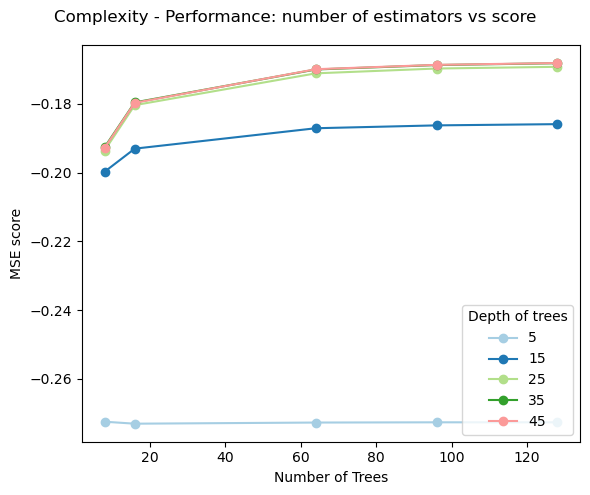

In [79]:
compare_forests( pd.DataFrame(forest.cv_results_) )

### comment? 

In [80]:
forest_pred = best_forest.predict(X_test)
scores = compute_scores(X_test, y_test, forest_pred)
save_scores('RandomForest', scores)

MSE: 0.2006
MAE: 0.3434
MR: -0.0022
adj-R2: 0.7892


In [81]:
export_pred(forest_pred, 'RandomForest')

# 6. XGBoost 

First we explore the default parameters, then move on to cross validation.

In [82]:
from xgboost import XGBRegressor
import time

In [83]:
xgbr = XGBRegressor(tree_method="hist")
start = time.time()
xgbr.fit(X, yf)
elapsed = time.time() - start
print(f'XGB Training ran in {elapsed:.5f} seconds')

XGB Training ran in 0.43473 seconds


In [84]:
xgbr_pred = xgbr.predict(X_test)
scores = compute_scores(X_test, y_test, xgbr_pred)
save_scores('XGBoost_def', scores)

MSE: 0.1923
MAE: 0.3378
MR: -0.0029
adj-R2: 0.7979


## Cross Validation

In [85]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [16, 64, 128],
    'learning_rate': [0.01, 0.1, 0.2, 0.3], # def 0.3
    'max_depth': [3, 4, 6],                 # def 0.6
    'min_child_weight': [1, 2, 3],          # def 1
    'gamma': [0, 0.1, 0.2], # def 0, minimum loss reduction required for further tree splits
    'reg_alpha': [0, 0.5],      # def 0, L1 regularization to the feature weights
    'reg_lambda': [0.5, 1],     # def 1, L2 regularization to the feature weights
    'subsample': [0.8, 1.0],    # def 1
    'colsample_bytree': [0.8, 1.0]} # def 1

In [86]:
xgbr = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', verbose=2)


In [87]:
xgbr.fit(X, yf)

print(f"\nBest XGBRegressor with params: {xgbr.best_params_} and MSE: {xgbr.best_score_:.3f}")

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, 

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, 

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, 

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subs

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, 

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subs

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_la

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_la

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_la

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_la

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_la

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_la

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lamb

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0;

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, s

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0;

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, s

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0;

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, s

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0;

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, s

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0;

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, 

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsampl

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsampl

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=12

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, 

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0,

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, re

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alph

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, 

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, re

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alp

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, 

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alp

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alp

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, 

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_a

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, 

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, 

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_la

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, r

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lamb

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, re

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_l

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alp

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_l

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alp

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_l

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alp

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, 

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_l

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lamb

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lamb

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, re

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, re

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, re

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, re

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, 

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, r

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alp

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_a

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alp

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, 

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lamb

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_a

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, 

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alp

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=12

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alp

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=12

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0,

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, 

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lamb

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lamb

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, re

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, re

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, re

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, re

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, 

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, r

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, re

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lamb

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_la

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, re

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, 

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, re

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, 

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, re

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, re

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, re

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_l

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsampl

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsampl

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_la

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsampl

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lamb

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambd

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsampl

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lamb

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambd

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subs

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0;

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5,

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subs

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0;

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsampl

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsampl

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsampl

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsampl

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsampl

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsam

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsam

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, su

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alp

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=12

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0,

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, 

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lamb

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, 

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alp

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, 

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, r

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, 

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_a

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, 

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, re

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lamb

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, re

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_l

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alp

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_l

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alp

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, 

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_l

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lamb

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lamb

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, re

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, re

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, r

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, re

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lamb

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, 

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, reg

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, r

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, 

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, reg_alp

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=12

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, reg_alph

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, re

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=12

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, reg_alp

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, 

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, re

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, reg

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, re

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, re

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, r

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, re

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lamb

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0.5

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0, re

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0, re

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, 

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, re

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, reg

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, reg_alpha=0, 

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=1, 

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_la

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, reg

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, reg_alpha=0, r

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, reg_alpha=0, reg_lambda

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=0.5

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, reg

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, reg_alpha=0.5, reg_

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, reg_alpha=0, re

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, reg

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, reg_alpha=0.5, 

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0, reg_

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, reg_alpha=0, reg_la

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, reg_alpha=0, reg_lambda=1, su

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, reg_alp

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, reg_alpha=0

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_lambda=1, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, reg_alpha=0.5, reg_

In [88]:
# Creating a XGB model with the selected parameters
best_xgbr = XGBRegressor(max_depth=xgbr.best_params_['max_depth'],
                        n_estimators=xgbr.best_params_['n_estimators'],
                        learning_rate=xgbr.best_params_['learning_rate'],
                        min_child_weight=xgbr.best_params_['min_child_weight'], 
                        gamma=xgbr.best_params_['gamma'],
                        alpha=xgbr.best_params_['reg_alpha'],
                        reg_lambda=xgbr.best_params_['reg_lambda'],
                        subsample=xgbr.best_params_['subsample'],
                        colsample_bytree=xgbr.best_params_['colsample_bytree']
                        )
best_xgbr.fit(X, yf)

XGBRegressor(alpha=0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=128, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [89]:
xgb_pred = best_xgbr.predict(X_test)
scores = compute_scores(X_test, y_test, xgb_pred)

save_scores('XGBoost', scores)

MSE: 0.1900
MAE: 0.3360
MR: -0.0023
adj-R2: 0.8003


In [90]:
export_pred(xgb_pred, 'XGBoost')

# 7. Light GBM

In [91]:
from lightgbm import LGBMRegressor

In [92]:
lgbm = LGBMRegressor()
start = time.time()
lgbm.fit(X, yf)
elapsed = time.time() - start
print(f'LGBM Training ran in {elapsed:.5f} seconds')

LGBM Training ran in 0.67609 seconds


In [93]:
lgbm_pred = lgbm.predict(X_test)
scores = compute_scores(X_test, y_test, lgbm_pred)
save_scores('LightGBM_def', scores)

MSE: 0.1936
MAE: 0.3399
MR: -0.0012
adj-R2: 0.7966


## Cross Validation

In [94]:
# Define the parameter grid to search
param_grid = {
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  
    'max_depth': [3, 4, 6],                  
    'min_child_weight': [1, 2, 3], 
    'num_leaves': [8, 16, 32, 64],
    'n_estimators': [16, 64, 128],
    'reg_alpha': [0, 0.5],                   # L1 regularization
    'reg_lambda': [0.5, 1],                  # L2 regularization
}

In [95]:
lgbm = GridSearchCV(estimator=LGBMRegressor(), param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', verbose=2)

In [96]:
lgbm.fit(X, yf)

print(f"\nBest LGBMRegressor with params: {lgbm.best_params_} and MSE: {lgbm.best_score_:.3f}")

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=8, reg_

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] E

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END c

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END c

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END col

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV]

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END c

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[C

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsampl

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END cols

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END c

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] E

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.4s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END col

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] E

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END col

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END c

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, l

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, l

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8,

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END col

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytr

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, l

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END col

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.4s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, lea

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END col

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learnin

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8,

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytr

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8,

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_by

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] E

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learn

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END col

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytr

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END col

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] E

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8,

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, l

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, l

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END col

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytr

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learn

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, l

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_by

[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV]

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, l

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END col

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] E

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END c

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_b

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] E

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END col

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_by

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, l

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END col

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END c

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.7s
[CV] END c

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END col

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END col

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytr

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, l

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_b

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_b

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0,

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0,

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END c

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0,

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0,

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.4s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END col

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.4s
[CV] END c

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0,

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsampl

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] E

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0,

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0,

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, l

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0,

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END c

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, l

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0,

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learn

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.4s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_b

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0,

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0,

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END c

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0,

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0,

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, l

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0,

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END col

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END col

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_b

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsa

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_b

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=16, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=16, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, l

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=8, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=128, num_leaves=32, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END colsample_b

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=16, reg_alpha=0, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytr

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=16, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END col

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=64, num_leaves=32, reg_alpha=0, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=8, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=128, num_leaves=64, reg_alpha=0, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytre

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=16, num_leaves=16, reg_alpha=0.5, reg_lambda=1; total time=   0.1s
[CV] END colsample_b

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=8, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learn

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=32, reg_alpha=0.5, reg_lambda=1; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=64, num_leaves=64, reg_alpha=0, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_byt

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0, reg_lambda=1; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=16, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s
[CV] END colsamp

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=1; total time=   0.5s

Best LGBMRegressor with params: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 128, 'num_leaves': 64, 'reg_alpha': 0.5, 'reg_lambda': 0.5} and MSE: -0.180


Best LGBMRegressor with params: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 128, 'num_leaves': 64, 'reg_alpha': 0.5, 'reg_lambda': 1} and MSE: -0.176


In [97]:
# Creating a XGB model with the selected parameters
best_lgbm = LGBMRegressor(max_depth=lgbm.best_params_['max_depth'],
                        n_estimators=lgbm.best_params_['n_estimators'],
                        learning_rate=lgbm.best_params_['learning_rate'],
                        min_child_weight=lgbm.best_params_['min_child_weight'], 
                        reg_alpha=lgbm.best_params_['reg_alpha'],
                        reg_lambda=lgbm.best_params_['reg_lambda'],
                        colsample_bytree=lgbm.best_params_['colsample_bytree'],
                        num_leaves=lgbm.best_params_['num_leaves'],
                        )
best_lgbm.fit(X, yf)

LGBMRegressor(learning_rate=0.3, max_depth=6, min_child_weight=1,
              n_estimators=128, num_leaves=64, reg_alpha=0.5, reg_lambda=0.5)

In [98]:
lgbm_pred = best_lgbm.predict(X_test)
scores = compute_scores(X_test, y_test, lgbm_pred)

save_scores('LightGBM', scores)

MSE: 0.1896
MAE: 0.3352
MR: -0.0059
adj-R2: 0.8008


In [99]:
export_pred(lgbm_pred, 'LightGBM')

# 8. Hybrid Regression

In [101]:
# Import predictions from csv files, which have been rescaled to the original scale
forest_pred = pd.read_csv('predictions/RandomForest_pred.csv', header=None)
xgbr_pred = pd.read_csv('predictions/XGBoost_pred.csv', header=None)
lgbm_pred = pd.read_csv('predictions/LightGBM_pred.csv', header=None)

In [102]:
# Define the weights for each model
weights = [1/3, 1/3, 1/3]  # Equal weights for each model

# Combine predictions using weighted average
hybrid_predictions = (weights[0] * forest_pred + 
                      weights[1] * xgbr_pred +     
                      weights[2] * lgbm_pred)

# Standardize, scale to the same scale of y_test
hybrid_predictions = ss_y.transform(np.array(hybrid_predictions).reshape(-1, 1))

In [103]:
scores = compute_scores(X_test, y_test, hybrid_predictions)
save_scores('HybridModel', scores)

MSE: 0.1834
MAE: 0.3293
MR: -0.0035
adj-R2: 0.8073


In [104]:
export_pred(hybrid_predictions, 'HybridModel')

# 9. Stacking
Architecture from Quang

In [105]:
from vecstack import StackingTransformer

# Initialize 1st level estimators
estimators = [('RF', RandomForestRegressor(max_depth=forest.best_params_['max_depth'], 
                                    n_estimators=forest.best_params_['n_estimators'])),
              ('LGBM', LGBMRegressor(max_depth=lgbm.best_params_['max_depth'],
                        n_estimators=lgbm.best_params_['n_estimators'],
                        learning_rate=lgbm.best_params_['learning_rate'],
                        min_child_weight=lgbm.best_params_['min_child_weight'], 
                        reg_alpha=lgbm.best_params_['reg_alpha'],
                        reg_lambda=lgbm.best_params_['reg_lambda'],
                        colsample_bytree=lgbm.best_params_['colsample_bytree'],
                        num_leaves=lgbm.best_params_['num_leaves'],
              ))]
              
# Initialize StackingTransformer
stack = StackingTransformer(estimators, regression=True, verbose=2, shuffle=True, metric=mean_squared_error)

In [106]:
stack = stack.fit(X, yf)

task:         [regression]
metric:       [mean_squared_error]
variant:      [A]
n_estimators: [2]

estimator  0: [RF: RandomForestRegressor]
    fold  0:  [0.17495287]
    fold  1:  [0.17101086]
    fold  2:  [0.16757973]
    fold  3:  [0.17319119]
    ----
    MEAN:     [0.17168366] + [0.00275024]

estimator  1: [LGBM: LGBMRegressor]
    fold  0:  [0.18154117]
    fold  1:  [0.18041365]
    fold  2:  [0.17523414]
    fold  3:  [0.18020558]
    ----
    MEAN:     [0.17934863] + [0.00242924]



In [108]:
# Get stacked features
S_train = stack.transform(X)
S_test = stack.transform(X_test)

Train set was detected.
Transforming...

estimator  0: [RF: RandomForestRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [LGBM: LGBMRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

Transforming...

estimator  0: [RF: RandomForestRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [LGBM: LGBMRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE



In [109]:
xgbr = XGBRegressor()
start = time.time()
xgbr.fit(S_train, yf)
elapsed = time.time() - start
print(f'XGB Stacking Training ran in {elapsed:.5f} seconds')

XGB Stacking Training ran in 0.55245 seconds


In [110]:
stacking_pred = xgbr.predict(S_test)
scores = compute_scores(S_test, y_test, stacking_pred)

save_scores('Stacking', scores)

MSE: 0.1907
MAE: 0.3348
MR: 0.0020
adj-R2: 0.7999


In [111]:
export_pred(stacking_pred, 'Stacking')

# FINAL SUMMARY OF METHODS PERFORMANCES

We display below a summary of the scores obtained by the different models. 
We see that models can be classified differently based on the metric of evaluation chosen. 




In [112]:
final_scores=display_scores()

In [113]:
final_scores.to_csv('final_scores.csv')

In [114]:
final_scores

method       MSE       MAE        MR adj R-squared
0   LinearRegression  0.284242  0.417012 -0.011339      0.701304
1             RANSAC  0.351169  0.464005 -0.027247      0.630982
2      NeuralNetwork  0.219969  0.363906  0.015084       0.76885
3      NeuralNetwork  0.218082  0.361823  0.034362      0.770834
4      NeuralNetwork  0.219969  0.363906  0.015084       0.76885
5     RegressionTree  0.240935  0.373035  -0.00134      0.746819
6     RegressionTree  0.240426  0.372986 -0.001379      0.747354
7       RandomForest  0.200587   0.34336  -0.00222      0.789218
8        XGBoost_def  0.192317  0.337828 -0.002903      0.797908
9            XGBoost  0.190047  0.335952 -0.002342      0.800293
10      LightGBM_def  0.193596  0.339926 -0.001223      0.796565
11          LightGBM  0.189557  0.335243 -0.005874      0.800808
12       HybridModel  0.183373  0.329291 -0.003479      0.807306
13          Stacking   0.19069  0.334824  0.001987      0.799932

# analisi finali
- predictions per anno vs reale (grafica)